# Step 1: Select Task/Dataset
I chose Tiny ImageNet, which contains 100000 images of 200 classes (500 for each class) resized to 64x64 color images.

In [2]:
from datasets import load_dataset
from classes import i2d
import json

In [3]:
dataset = load_dataset('Maysee/tiny-imagenet', split='train')

Found cached dataset parquet (/Users/haris.alic/.cache/huggingface/datasets/Maysee___parquet/Maysee--tiny-imagenet-2eb6c3acd8ebc62a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [4]:
dataset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64>,
 'label': 0}

In [5]:
with open("dataset_infos.json") as file:
    dataset_infos = json.load(file)

In [6]:
class_names = dataset_infos["Maysee--tiny-imagenet"]["features"]["label"]["names"]
idx2class = {i: class_names[i] for i in range(len(class_names))}

# Step 2: Get to know the data
The dataset is well balanced and has 500 images for each class

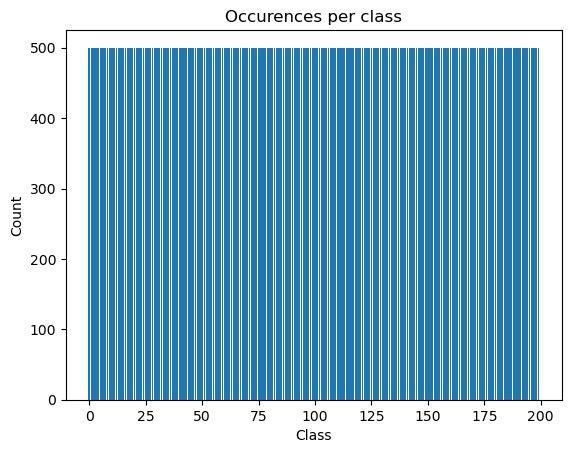

In [7]:
from collections import defaultdict
import matplotlib.pyplot as plt

class_counts = defaultdict(int)
for instance in dataset:
    label = instance['label']
    class_counts[label] += 1

plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Count')
plt.title("Occurences per class")
plt.show()


# Step 3: Structure Modeling

### Step 3.1 Determine how (with which metrics) you want to evaluate your model. Also, consider the error in estimating the metrics.
We will use accuracy to evaluate our model.

### Step 3.2 Implement basic functionality to train models and evaluate them against each other. It is recommended to use a suitable MLOps platform (e.g. W&B)

In [7]:
from tin import TinyImageNetDataset
from torch.utils.data import DataLoader
from torchvision import transforms, models
from sklearn.metrics import precision_score, recall_score, f1_score

/Users/haris.alic/Dev/github/hariveliki/del/tin.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [8]:
# Define a custom Dataset class because the dataset from load_dataset() is useless
train_data = TinyImageNetDataset(root_dir="./data/tiny-imagenet-200", mode="train")
val_data = TinyImageNetDataset(root_dir="./data/tiny-imagenet-200", mode="val")
test_data = TinyImageNetDataset(root_dir="./data/tiny-imagenet-200", mode="test")

Preloading train data...:   0%|          | 0/100000 [00:00<?, ?it/s]

Preloading val data...:   0%|          | 0/10000 [00:00<?, ?it/s]

Preloading test data...:   0%|          | 0/10000 [00:00<?, ?it/s]

In [9]:
import torch
# reduce the size of train_data by x
train_data = torch.utils.data.Subset(train_data, range(0, len(train_data), 1))
print(f"train_data size: {len(train_data)}")
val_data = torch.utils.data.Subset(val_data, range(0, len(val_data), 1))
print(f"val_data size: {len(val_data)}")
test_data = torch.utils.data.Subset(test_data, range(0, len(test_data), 1))
print(f"test_data size: {len(test_data)}")

train_data size: 100000
val_data size: 10000
test_data size: 10000


In [10]:
BATCH_SIZE = 64
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
print(f"There are {len(train_loader)} batches in the training set")
print(f"There are {len(val_loader)} batches in the validation set")

There are 1563 batches in the training set
There are 157 batches in the validation set


In [11]:
device = None
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


## Step 3.2.1: Model

In [22]:
import torch.nn as nn
import utils
from typing import List

class CNN_MLP(nn.Module):
    def __init__(
            self,
            dim: int,
            num_classes: int,
            layers: list,
            confs: List[dict],
            in_channels: int,
            out_channels: int,
            dropout=0.5,
            weight_init=None):
        super(CNN_MLP, self).__init__()

        self.net = nn.ModuleList()

        for layer, conf in zip(layers, confs):
            if layer == "C":
                self.net.append(
                    nn.Conv2d(
                        in_channels,
                        out_channels,
                        kernel_size=conf["kernel"],
                        stride=conf["stride"],
                        padding=conf["padding"]
                    )
                )
                # self.net.append(nn.BatchNorm2d(out_channels))
                self.net.append(nn.ReLU())
                self.net.append(nn.BatchNorm2d(out_channels))
                in_channels = out_channels
                out_channels = conf["channels"]
            elif layer == "P":
                self.net.append(
                    nn.MaxPool2d(kernel_size=conf["kernel"])
                )
        
        self.flatten = nn.Flatten()
        self.in_channels = in_channels
        self.dim = utils.get_dim_after_conv_and_pool(
            dim_init=dim,
            layers=layers,
            confs=confs
        )
        print(f"self.dim: {self.dim},\nself.in_channels: {self.in_channels}")
        self.fc1 = nn.Linear(self.dim * self.dim * self.in_channels, 500)
        # self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, num_classes)
        self.dropout = nn.Dropout(dropout)


    def forward(self, x):
        N = x.shape[0]
        C, H, W = x.shape[3], x.shape[1], x.shape[2]
        x = x.permute(0, 3, 1, 2)  # From (batch_size, H, W, C) to (batch_size, C, H, W)
        assert x.shape == (N, C, H, W)
        
        for layer in self.net:
            x = layer(x)

        x = self.flatten(x)
        x = self.dropout(x)
        x = nn.ReLU()(self.fc1(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

## Hyperparameters

In [23]:
EPOCHS = 40
BATCH_SIZE = BATCH_SIZE
LEARNING_RATE = 0.001
SEED = 42
WEIGHT_DECAY = None
DROPOUT = 0.5
BATCH_NORM = True
OPTIMIZER = "Adam"

## Step 3.2.2: Model Init

In [25]:
import copy
from torchsummary import summary
import torch.optim as optim
torch.manual_seed(SEED)

layers = ["C", "C", "P", "C", "C", "P", "C", "C", "P"]
confs = [
    {"kernel": 3, "stride": 1, "padding": 1, "channels": 16},
    {"kernel": 3, "stride": 1, "padding": 1, "channels": 32},
    {"kernel": 2},
    {"kernel": 3, "stride": 1, "padding": 1, "channels": 64},
    {"kernel": 3, "stride": 1, "padding": 1, "channels": 64},
    {"kernel": 2},
    {"kernel": 3, "stride": 1, "padding": 1, "channels": 128},
    {"kernel": 3, "stride": 1, "padding": 1, "channels": 128},
    {"kernel": 2},
]

model = CNN_MLP(
    dim=64,
    num_classes=200,
    layers=layers,
    confs=confs,
    in_channels=3,
    out_channels=16,
    dropout=DROPOUT
)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
print(f"Epochs: {EPOCHS}\nBatch size: {BATCH_SIZE}\n\
Learning rate: {LEARNING_RATE}\nSeed: {SEED}\nWeight Decay: {WEIGHT_DECAY}\n\
Dropout: {DROPOUT}\nBatch Norm: {BATCH_NORM}\nOptimizer: {OPTIMIZER}")
print(model)
summary(model)

self.dim: 8,
self.in_channels: 128
Epochs: 40
Batch size: 64
Learning rate: 0.001
Seed: 42
Weight Decay: None
Dropout: 0.5
Batch Norm: True
Optimizer: Adam
CNN_MLP(
  (net): ModuleList(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13)

Layer (type:depth-idx)                   Param #
├─ModuleList: 1-1                        --
|    └─Conv2d: 2-1                       448
|    └─ReLU: 2-2                         --
|    └─BatchNorm2d: 2-3                  32
|    └─Conv2d: 2-4                       2,320
|    └─ReLU: 2-5                         --
|    └─BatchNorm2d: 2-6                  32
|    └─MaxPool2d: 2-7                    --
|    └─Conv2d: 2-8                       4,640
|    └─ReLU: 2-9                         --
|    └─BatchNorm2d: 2-10                 64
|    └─Conv2d: 2-11                      18,496
|    └─ReLU: 2-12                        --
|    └─BatchNorm2d: 2-13                 128
|    └─MaxPool2d: 2-14                   --
|    └─Conv2d: 2-15                      36,928
|    └─ReLU: 2-16                        --
|    └─BatchNorm2d: 2-17                 128
|    └─Conv2d: 2-18                      73,856
|    └─ReLU: 2-19                        --
|    └─BatchNorm2d: 2-20                 256
|    

## Step 3.2.3: Model Train

In [26]:
import wandb
%env WANDB_SILENT=true
%env PYTORCH_ENABLE_MPS_FALLBACK=1
try:
    wandb.login()
    wandb.init(project="del",
               entity="hariveliki")
    wandb.define_metric("epoch")
    wandb.define_metric("loss_train", step_metric="epoch")
    wandb.define_metric("loss_eval", step_metric="epoch")
    wandb.define_metric("train_accuracy", step_metric="epoch")
    wandb.define_metric("eval_accuracy", step_metric="epoch")
    wandb.define_metric("f1_macro", step_metric="epoch")
    wandb.define_metric("precision", step_metric="epoch")
    wandb.define_metric("recall", step_metric="epoch")

    model.to(device)
    for epoch in range(1, EPOCHS+1):
        print(f"|---------------------------| Start Epoch {epoch}: |---------------------------|")
        loss_train = 0
        total = 0
        correct = 0
        model.train()
        for n, batch in enumerate(train_loader):
            imgs = batch["image"]
            imgs = imgs.to(device)
            labels = batch["label"]
            labels = labels.to(device)

            # Forward pass
            labels = labels.long()
            logits = model(imgs)
            preds = nn.functional.softmax(logits, dim=1)
            loss = criterion(logits, labels)
            loss_train += loss.item()
            predicted = preds.argmax(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_train /= len(train_loader)
        train_accuracy = 100 * correct / total
        print(f"Train Loss: {loss_train}")
        print(f"Train Accuracy: {train_accuracy}")

        correct = 0
        total = 0
        loss_eval = 0
        model.eval()
        for n, batch in enumerate(val_loader):
            imgs = batch["image"]
            imgs = imgs.to(device)
            labels = batch["label"]
            labels = labels.to(device)

            # Forward pass
            labels = labels.long()
            logits = model(imgs)
            preds = nn.functional.softmax(logits, dim=1)
            loss_eval += criterion(logits, labels).item()
            predicted = preds.argmax(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        loss_eval /= len(val_loader)
        eval_accuracy = 100 * correct / total
        print(f"Eval Loss: {loss_eval}")
        print(f"Eval Accuracy: {eval_accuracy}")
        wandb.log(
            {
                "epoch": epoch,
                "loss_train": loss_train,
                "loss_eval": loss_eval,
                "train_accuracy": train_accuracy,
                "eval_accuracy": eval_accuracy
            }
        )

    wandb.finish()

except Exception as e:
    wandb.finish()
    raise e

except KeyboardInterrupt:
    wandb.finish()
    raise KeyboardInterrupt

env: WANDB_SILENT=true
env: PYTORCH_ENABLE_MPS_FALLBACK=1
|---------------------------| Start Epoch 1: |---------------------------|
Train Loss: 5.221913453637219
Train Accuracy: 1.096
Eval Loss: 5.042434437259747
Eval Accuracy: 1.9
|---------------------------| Start Epoch 2: |---------------------------|
Train Loss: 5.102122197605751
Train Accuracy: 1.419
Eval Loss: 4.910566876648338
Eval Accuracy: 2.88
|---------------------------| Start Epoch 3: |---------------------------|
Train Loss: 5.010724197651283
Train Accuracy: 1.905
Eval Loss: 4.786122136814579
Eval Accuracy: 3.99
|---------------------------| Start Epoch 4: |---------------------------|
Train Loss: 4.919468417811379
Train Accuracy: 2.563
Eval Loss: 4.629715615776694
Eval Accuracy: 5.46
|---------------------------| Start Epoch 5: |---------------------------|
Train Loss: 4.787711892155448
Train Accuracy: 3.487
Eval Loss: 4.484924143287027
Eval Accuracy: 6.94
|---------------------------| Start Epoch 6: |-----------------

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


# Step 4: Evaluation

## SGD
After finding a working learning rate, we train with the entire data set and only with SGD given the architecture below.  
We see an increasing eval loss after few epochs which indicates overfitting.  

Architecture:  
3x3 conv, 16  
pool, 2/  
3x3 conv, 32  
pool, 2/  

fc 500  
fc 500  
fc 200  

<img src="plots/3_loss_train_eval.png" width="800" height="500">
<img src="plots/3_acc_train_eval.png" width="800" height="500">

## Stride
We introduced Stride within the convolutions to reduce the number of parameters and decrease the distance between train and evaluation loss.  
The introduction of Stride resulted in better performance than before, but still overfitting between 5 and 10 epochs.  
In hindsight, it was the wrong decision to introduce Stride into the convolutions, as there was already a pooling layer performing the same dimensionality reduction task.  
It was no longer possible to increase the size of the architecture.  
In later architecture decisions, we only used pooling without stride in the convolutions.  

Architecture:  
3x3 conv, 16  (stride)  
pool, 2/  
3x3 conv, 32  (stride)  
pool, 2/  

fc 500  
fc 500  
fc 200  

<img src="plots/4_loss_train_eval.png" width="800" height="500">
<img src="plots/4_acc_train_eval.png" width="800" height="500">

## Padding and Stride
Based on the same architecture as before with stride we added padding which pads the input volume with zeros around the border.  
Therefore we preserve the spatial dimension from decreasing and keep as much information about the original input volume as possible, so that we can extract those low level features.  
We see a better performance than before and overfitting only after 10 epochs.  

Architecture:  
3x3 conv, 16  (stride, padding)  
pool, 2/  
3x3 conv, 32  (stride, padding)  
pool, 2/  

fc 500  
fc 500  
fc 200 

<img src="plots/5_loss_train_eval.png" width="800" height="500">
<img src="plots/5_acc_train_eval.png" width="800" height="500">

## New Architecture
After discussions with the expert, we changed the architecture and used more convolution layers and reduced the number of fully connected layers.  
We also removed the stride from the convolution layers this time and kept the padding.  
This architecture defined our new baseline.  
As we now had many more parameters due to the increase in convolution layers, overfitting occurred again very quickly.  

Architecture:  
3x3 conv, 16  
3x3 conv, 32  
pool, 2/  
3x3 conv, 64  
3x3 conv, 64  
pool, 2/  
3x3 conv, 128  
3x3 conv, 128  
pool, 2/  

fc 500  
fc 200  

<img src="plots/6_loss_train_eval.png" width="800" height="500">
<img src="plots/6_acc_train_eval.png" width="800" height="500">

## L2 Regularization
We tried l2 aka weight decay regularization to reduce overfitting.  
But comparing the previous result with the regularization, we don't see much difference.  

Architecture:  
3x3 conv, 16  
3x3 conv, 32  
pool, 2/  
3x3 conv, 64  
3x3 conv, 64  
pool, 2/  
3x3 conv, 128  
3x3 conv, 128  
pool, 2/  

fc 500  
fc 200  

<img src="plots/7_6_loss_train_eval.png" width="800" height="500">
<img src="plots/7_6_acc_train_eval.png" width="800" height="500">

## Dropout
Using another regularization technique called dropout gave us much better results.  
We see overfitting only after 20 epochs.  
The green curves are with l2 regularization and the orange curves are with dropout.  

Architecture:  
3x3 conv, 16  
3x3 conv, 32  
pool, 2/  
3x3 conv, 64  
3x3 conv, 64  
pool, 2/  
3x3 conv, 128  
3x3 conv, 128  
pool, 2/  

dropout
fc 500  
dropout   
fc 200  

<img src="plots/8_7_loss_train_eval.png" width="800" height="500">
<img src="plots/8_7_acc_train_eval.png" width="800" height="500">

## Batch Norm
Now we have tried batch norm and investigated how it affects the performance of the model.  
It resulted in faster and lower losses and higher accuracy compared to dropout, but was not as good at generalizing to unseen data.  
The red curves are with dropout and the orange curves are with batch norm.  

Architecture:  
3x3 conv, 16  (batchnorm)  
3x3 conv, 32  (batchnorm)  
pool, 2/  
3x3 conv, 64  (batchnorm)  
3x3 conv, 64  (batchnorm)  
pool, 2/  
3x3 conv, 128  (batchnorm)  
3x3 conv, 128  (batchnorm)  
pool, 2/  

fc 500  
fc 200  

<img src="plots/8_loss_train_eval.png" width="800" height="500">
<img src="plots/8_acc_train_eval.png" width="800" height="500">

##  Dropout and Batch Norm  
Drop out and batch norm combined gave us the best result so far.  
The loss curves and the small gap between eval and train indicate that we could run more epochs and get even better results.  

Architecture:  
3x3 conv, 16  (batchnorm)  
3x3 conv, 32  (batchnorm)  
pool, 2/  
3x3 conv, 64  (batchnorm)  
3x3 conv, 64  (batchnorm)  
pool, 2/  
3x3 conv, 128  (batchnorm)  
3x3 conv, 128  (batchnorm)  
pool, 2/   

dropout  
fc 500  
dropout   
fc 200  

<img src="plots/8_do_bn_loss_train_eval.png" width=800 height=500>
<img src="plots/8_do_bn_acc_train_eval.png" width=800 height=500>

## Adam Optimizer
Finally using Adam as optimizer lead to a much faster convergence, we achieved better results in less epochs.  
We could stop the training after 15 epochs and still get better results than before.  

Architecture:  
3x3 conv, 16  (batchnorm)  
3x3 conv, 32  (batchnorm)  
pool, 2/  
3x3 conv, 64  (batchnorm)  
3x3 conv, 64  (batchnorm)  
pool, 2/  
3x3 conv, 128  (batchnorm)  
3x3 conv, 128  (batchnorm)  
pool, 2/   

dropout  
fc 500  
dropout   
fc 200  

<img src="plots/9_8_loss_train_eval.png" width="800" height="500">
<img src="plots/9_8_acc_train_eval.png" width="800" height="500">